In [15]:
class TreeNode:
  def __init__(self,left,right,parent,cutoff_id,cutoff_val,prediction):

    self.left=left
    self.right=right
    self.parent=parent
    self.cutoff_id=cutoff_id
    self.cutoff_val=cutoff_val
    self.prediction=prediction

In [16]:
%matplotlib inline

#<GRADED>
import numpy as np
from numpy.matlib import repmat
import sys
import time
#</GRADED>
import matplotlib.pyplot as plt
from scipy.io import loadmat

# load in some binary test data (labels are -1, +1)
data = loadmat("ion.mat")
xTr  = data['xTr'].T
yTr  = data['yTr'].flatten()
xTe  = data['xTe'].T
yTe  = data['yTe'].flatten()

# cut off the first two dimensions for visualization
xTr2d = xTr[:, 0:2]
xTe2d = xTe[:, 0:2]

print(xTr.shape, yTr.shape, xTe.shape, yTe.shape)

(281, 34) (281,) (70, 34) (70,)


In [17]:
def sqsplit(xTr,yTr,weight=[]):
  n,d=xTr.shape
  assert n>1
  assert d>0

  if len(weight)==0:
    weight=np.ones(n)

  weight=weight/float(sum(weight))

  best_loss=np.inf
  best_cut=np.inf
  feature=0

  for i in range(d):

    x_vals=xTr[xTr[:,i].argsort()]
    y_vals=yTr[xTr[:,i].argsort()]
    w=weight[xTr[:,i].argsort()]

    y_l=y_vals[0]
    w_l=w[0]
    y_r=np.delete(y_vals,0,0)
    w_r=np.delete(w,0,0)



    t_l=np.dot(w_l,y_l)/np.sum(w_l)
    t_r=np.dot(w_r,y_r)/np.sum(w_r)


    for j in range(n-1):



        y_upd1=y_l-t_l
        val1=np.dot(w_l,np.square(y_upd1))
        y_upd2=y_r-t_r
        val2=np.dot(w_r,np.square(y_upd2))
        total_loss=val1+val2

        cut_val=x_vals[j][i]

        if cut_val != x_vals[j+1][i] and total_loss <= best_loss:
          best_loss=total_loss
          best_cut=cut_val
          feature=i

        if(j!= n-2):

          y_l=np.append(y_l,y_r[0])
          y_r=np.delete(y_r,0,0)
          w_l=np.append(w_l,w_r[0])
          w_r=np.delete(w_r,0,0)

          t_l=np.dot(w_l,y_l)/np.sum(w_l)
          t_r=np.dot(w_r,y_r)/np.sum(w_r)





  return best_loss,best_cut,feature

loss,cut,fid = sqsplit(xTr,yTr)
print("Split on feature",fid,"on value:",cut)


X = np.array([
    [6.0, 2.0],  # Row 1
    [2.0, 8.0],  # Row 2
    [10.0, 4.0], # Row 3
    [3.0, 1.0],  # Row 4
    [8.0, 6.0]   # Row 5
])# nxd

 # y=np.array([1,2,0,-1,-2]) #n
  #w=np.array([1,2,1,1,1]) #n
  #sqsplit(X,y)

Split on feature 2 on value: 0.29920161791103117


The code below indicates falsa cart fuction since;


*   Instead of using the weighted prediction
prediction
=
np.dot
(
𝑤
,
𝑦
𝑇
𝑟
)
prediction=np.dot(w,yTr), it directly calculates
np.mean
(
𝑦
𝑇
𝑟
)
np.mean(yTr).
This ignores the impact of weights assigned to each data point, which might skew the predictions when weights are uneven.
*   If weights are provided as input, the code does not ensure that they sum to 1.
Without normalization, the weights lose their intended proportionality, leading to incorrect weighted calculations in splits and predictions.

* Manual Indexing: manually iterating over each row and checking the
condition, which is not only verbose but also increases the risk of errors like index mismatches or incorrectly splitting the data.NumPy's np.where provides a clear and concise way to split the data into left and right subsets based on the condition (xTr[:, feature] <= cut). This method is vectorized and runs much faster than using Python loops and lists.


So,

The code below does not incorporate the effect of weights into the predictions, which is important, especially in BOOSTING.

The weights should  be normalized.

Additionally, the code attempts to index manually, which is imprecise. You can use the np.where command instead of this.

In [18]:
def cart(xTr,yTr,depth=np.inf,weights=[]):
  n,d=xTr.shape
  if len(weights)==0:
      weights=np.ones(n)/float(n)
  else:
      weights=weights

  if depth==1 or n==1:
    tree=TreeNode(None, None, None, None, None, np.mean(yTr))
  else:
    loss,cut,feature=sqsplit(xTr,yTr,weights)

    if(feature == np.inf):
            feature=d-1
            cut=xTr[n-1][d-1]


    tree=None
  #check depth or row
    fl=[]
    fl_y=[]
    fl_w=[]
    fr=[]
    fr_y=[]
    fr_w=[]


    for i in range(n):


        if xTr[i][feature]<=cut:
          fl.append(xTr[i])
          fl_y.append(yTr[i])
          fl_w.append(weights[i])

        else:
          fr.append(xTr[i])
          fr_y.append(yTr[i])
          fr_w.append(weights[i])

    if len(fl)==0 or len(fr) == 0:
        tree=TreeNode(None,None,None,None,None,np.mean(yTr))
    else:
        l=np.array(fl)
        l_y=np.array(fl_y)
        l_w=np.array(fl_w)
        r=np.array(fr)
        r_y=np.array(fr_y)
        r_w=np.array(fr_w)

        if depth != np.inf:
          left=cart(l,l_y,depth-1,l_w)
          right=cart(r,r_y,depth-1,r_w)
        else:
          left=cart(l,l_y,np.inf,l_w)
          right=cart(r,r_y,np.inf,r_w)
        tree = TreeNode(None, None, None, 0, 0, yTr)
            #tree = TreeNode()
        tree.left = left
        tree.right = right
        tree.cutoff_id = feature
        tree.cutoff_val = cut
        tree.prediction = (left.prediction + right.prediction)/2
            #print(lft.prediction,"abc")
        left.parent = tree
        right.parent = tree
       # tree=TreeNode(left,right,None,feature,cut,(left.prediction+right.prediction)/2)
        #left.parent=tree
        #right.parent=tree

  return tree   # cart tree

X1 = np.array([

    [6.0, 2.0, 4.0],  # Row 1
    [2.0, 8.0 ,3.0],  # Row 2
    [10.0, 4.0, 7.0], # Row 3
    [3.0, 1.0,2.0],  # Row 4
    [8.0, 6.0, 1.5]   # Row 5
])# nxd

#y1=np.array([1,2,0,-1,-2]) #n
#w=np.array([1,2,1,1,1]) #n

#cart(xTr, yTr)


The code below is more precise

In [19]:
def cart(xTr,yTr,depth=np.inf,weights=None):
    """Builds a CART tree.

    The maximum tree depth is defined by "maxdepth" (maxdepth=2 means one split).
    Each example can be weighted with "weights".

    Args:
        xTr:      n x d matrix of data
        yTr:      n-dimensional vector
        maxdepth: maximum tree depth
        weights:  n-dimensional weight vector for data points

    Returns:
        tree: root of decision tree
    """
    n,d = xTr.shape
    if weights is None:
        w = np.ones(n) / float(n)
    else:
        w = weights

    prediction = np.dot(w, yTr)

    # Check for depth of 1, or all nodes have exactly 0 or 2 childen
    if depth == 1 or np.all(yTr == yTr[0]) or yTr.shape[0] < 2:
        return TreeNode(None, None, None, None, None, prediction)

    bestloss,cut,feature = sqsplit(xTr, yTr,w)
    tree = TreeNode(None, None, None, feature, cut, prediction)

    # Create split points
    split_L = np.where(xTr[:, feature] <= cut)
    split_R = np.where(xTr[:, feature] > cut)

    # Now split all data
    xL = xTr[split_L]
    xR = xTr[split_R]
    yL = yTr[split_L]
    yR = yTr[split_R]
    wL = w[split_L]
    wR = w[split_R]

    # Now recursive CART, setting current tree
    tree.left = cart(xL, yL, depth - 1, wL / sum(wL))
    tree.right = cart(xR, yR, depth - 1, wR / sum(wR))

    # Set current node parent to this tree now
    tree.left.parent = tree
    tree.left.parent = tree

    return tree

In [20]:
def cursor_tree(root,point):
  if root.left==None or root.right==None:
    return root.prediction

  if point[root.cutoff_id]<= root.cutoff_val:
      return cursor_tree(root.left,point)
  else:
      return cursor_tree(root.right,point)

def evaltree(root,point):


  n,d=point.shape
  tree_vals=np.zeros(n)
  for i in range(n):

    tree_vals[i]=cursor_tree(root,point[i])
  return tree_vals

#root1=cart(X1,y1)
#evaltree(root1,X1)

In [21]:
t0=time.time()

root=cart(xTr,yTr)
tr_error=np.mean((evaltree(root,xTr)-yTr)**2)
te_error=np.mean((evaltree(root,xTe)-yTe)**2)
print("train error:",tr_error)
print("test error: %.2f" %te_error)
t1=time.time()
print("%.2f seconds"%(t1-t0))


train error: 6.113803609252636e-30
test error: 0.97
2.06 seconds


Training error: 0.0000
Testing error:  0.2000


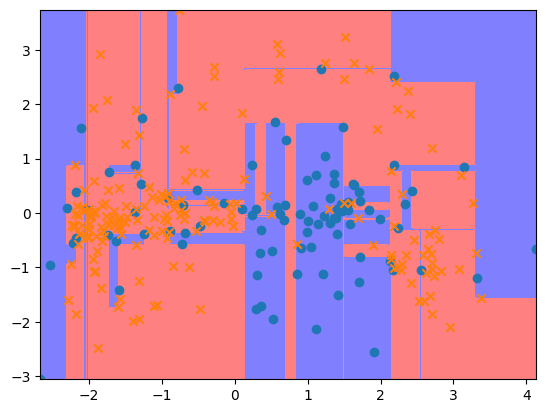

In [22]:
#def visclassifier(tree,xTr2d,yTr,w=[],b=0):
def visclassifier(func,xTr2d,yTr,w=[],b=0):
  # lets create background

  Xrange=np.linspace(min(xTr2d[:,0]),max(xTr2d[:,0]),300)
  yrange=np.linspace(min(xTr2d[:, 1]),max(xTr2d[:, 1]),300)

  pixelX=np.tile(Xrange,(300,1))
  pixely=np.tile(yrange,(300,1)).T


  #print(pixelX)
  #print()
  #print(pixely)

  xTotal=np.array([pixelX.flatten(),pixely.flatten()]).T
  #print()
  #print(xTotal)

  #testpreds=evaltree(tree,xTotal)
  testpreds=func(xTotal)
  z=testpreds.reshape(300,300)
  mycolors = [[0.5, 0.5, 1],[1, 0.5, 0.5]]
  plt.contourf(pixelX,pixely,z,colors=mycolors)
  n,d=xTr2d.shape

  # lets create dots
  markers=["o","x"]
  classvals=np.unique(yTr)
  for idc, val in enumerate(classvals):
      plt.scatter(xTr2d[yTr==val,0],xTr2d[yTr==val,1],marker=markers[idc])


tree=cart(xTr2d,yTr)
#visclassifier(tree,xTr2d,yTr,w=[],b=0)
visclassifier(lambda X : evaltree(tree,X),xTr2d,yTr,w=[],b=0)
print("Training error: %.4f" % np.mean(np.sign(evaltree(tree,xTr2d)) != yTr))
print("Testing error:  %.4f" % np.mean(np.sign(evaltree(tree,xTe2d)) != yTe))




In [23]:
def forest(xTr, yTr, m, maxdepth=np.inf):
  forest=[]
  n,d=xTr.shape
  for i in range(m):
    rand=np.random.randint(n, size=n)
    xRandom=xTr[rand,:]
    yRandom=yTr[rand]
    #tree=cart()
    #print(rand)
    #print(xRandom)
    root=cart(xRandom,yRandom,depth=maxdepth)

    forest.append(root)
  #print(len(forest))
  return forest
#print(forest(X,y,n))
#trees=forest

In [24]:

#trees=forest(xTr2d,yTr,100)
#evaltree(trees[2],xTr)

In [25]:
def evalforest(trees,x,alpha=None):
  n,d=x.shape
  m=len(trees)
  pred=np.zeros(n)
  if alpha==None:
    alpha=np.ones(m)/len(trees)
  for i in range(m):
   # pred=pred+alpha[i]*evaltree(trees[i],x)
    pred += evaltree(trees[i], x) * alpha[i]

  #pred= map(lambda i : alpha[i]* evaltree(trees[i],x),range(m)) w/o for loop
  return pred

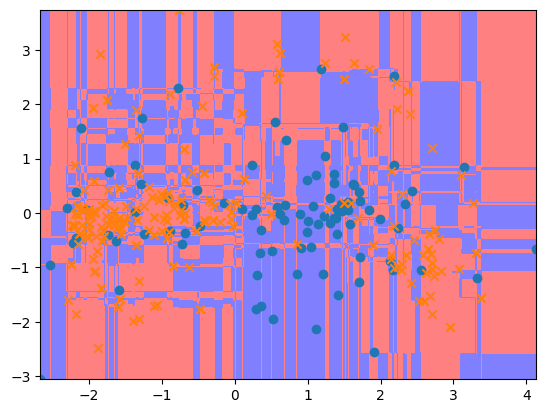

In [26]:
trees=forest(xTr2d,yTr,30)
visclassifier(lambda X : evalforest(trees,X),xTr2d,yTr)

In [27]:
print("training error:  %.4f"%np.mean(np.sign(evalforest(trees,xTr2d))!=yTr))
print("test error : %.4f"%np.mean(np.sign(evalforest(trees,xTe2d))!=yTe))

training error:  0.0036
test error : 0.1000


{0} th training error: 0.0854 	 test error: 0.1429
{1} th training error: 0.1388 	 test error: 0.2286
{2} th training error: 0.0712 	 test error: 0.1857
{3} th training error: 0.0676 	 test error: 0.1857
{4} th training error: 0.0391 	 test error: 0.1429
{5} th training error: 0.0498 	 test error: 0.1857
{6} th training error: 0.0249 	 test error: 0.1429
{7} th training error: 0.0320 	 test error: 0.1571
{8} th training error: 0.0249 	 test error: 0.1286
{9} th training error: 0.0285 	 test error: 0.1429
{10} th training error: 0.0214 	 test error: 0.1286
{11} th training error: 0.0178 	 test error: 0.1429
{12} th training error: 0.0320 	 test error: 0.1571
{13} th training error: 0.0071 	 test error: 0.1429
{14} th training error: 0.0142 	 test error: 0.1000
{15} th training error: 0.0178 	 test error: 0.1429
{16} th training error: 0.0107 	 test error: 0.1143
{17} th training error: 0.0214 	 test error: 0.1429
{18} th training error: 0.0142 	 test error: 0.1000
{19} th training error

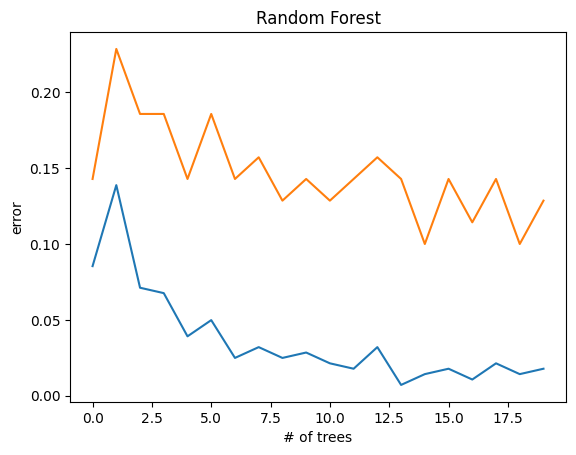

In [28]:
M=20
error_train=[]
error_test=[]
for i in range(M):
  trees=forest(xTr2d,yTr,i+1)
  error_tr=np.mean(np.sign(evalforest(trees,xTr2d))!=yTr)
  error_te=np.mean(np.sign(evalforest(trees,xTe2d))!=yTe)
  error_train.append(error_tr)
  error_test.append(error_te)
  print("{%i} th training error: %.4f \t test error: %.4f"%(i,error_tr,error_te))
plt.plot(range(M),error_train,label="Training Error")
plt.plot(range(M),error_test,label="Testing Error")
plt.title("Random Forest")
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()

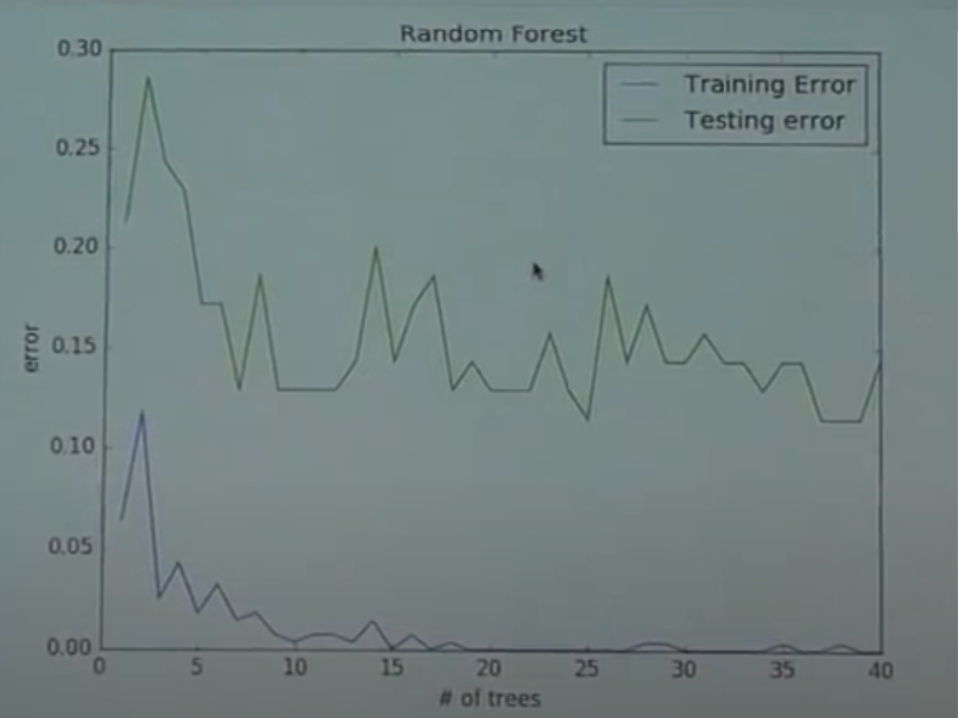

In [29]:
def boosttree(x,y,maxiter=100,maxdepth=2):
    """Learns a boosted decision tree.

    Input:
        x:        n x d matrix of data points
        y:        n-dimensional vector of labels
        maxiter:  maximum number of trees
        maxdepth: maximum depth of a tree

    Output:
        forest: list of TreeNode decision trees of length m
        alphas: m-dimensional weight vector

    (note, m is at most maxiter, but may be smaller,
    as dictated by the Adaboost algorithm)
    """
    assert np.allclose(np.unique(y), np.array([-1,1])); # the labels must be -1 and 1
    n,d = x.shape
    weights = np.ones(n) / n
    preds   = None
    forest  = []
    alphas  = []

    epsilon = 0

    for t in range(maxiter):
        tree = cart(x, y, maxdepth, weights)
        preds = evaltree(tree, x)
        epsilon = np.multiply(np.where(np.sign(preds) != y, 1, 0), weights).sum()
        #we obtain € val now we can evaluate amount of say which is =1/2*log(1-€/€)

        if epsilon < 0.5:
            alpha = 0.5 * np.log((1 - epsilon) / epsilon)  #amount of say

            alphas.append(alpha)
            forest.append(tree)

            num = np.multiply(weights, np.exp(-alpha * preds * y)) #we want to increase weight of incorrect prediction and decrease correct one
                                                                   #new weight= old weight*e^-(amount of say * (preds*y) )--> if true preds*y :1 --> make e^negative
            dom = 2 * (np.sqrt(epsilon * (1 - epsilon))) # for normalization                                                   # else: preds*y :-1 --> make e^ positive

            weights = num / dom  # we update weights where incorret ones > correct ones
        else:
            break

    return forest, alphas
boosttree(xTr2d,yTr,maxiter=100,maxdepth=2)

([<__main__.TreeNode at 0x7d43742ed2a0>,
 [0.43471321144896863,
  0.2692402533814288,
  0.15341849702078458,
  0.21225023611082836,
  0.09256027259559081,
  0.08580484919542633,
  0.07642584775540205,
  0.18844662187161235,
  0.09064642267494023,
  0.038873544824936136,
  0.03728603112054992,
  0.06395140522904422,
  0.03959000848506387,
  0.03782135732431352,
  0.16797655316704518,
  0.09577972059243145,
  0.04092143962477243,
  0.06650585190910174,
  0.041359710095223635,
  0.06218192169781578,
  0.1516386730479476,
  0.08243929121570293,
  0.04216456141541434,
  0.039172322746487145,
  0.05754684223500061,
  0.11937601089852529,
  0.03888819132127402,
  0.03607558118852742,
  0.0744791376867349,
  0.02450549992104956])

1 count forest --> test error: 0.1429 train error: 0.0000 exponential loss: 1.0000 
2 count forest --> test error: 0.2000 train error: 0.0000 exponential loss: 0.4630 
3 count forest --> test error: 0.1714 train error: 0.0000 exponential loss: 0.2723 
4 count forest --> test error: 0.1571 train error: 0.0000 exponential loss: 0.1297 
5 count forest --> test error: 0.1143 train error: 0.0000 exponential loss: 0.0804 
6 count forest --> test error: 0.1000 train error: 0.0000 exponential loss: 0.0479 
7 count forest --> test error: 0.1143 train error: 0.0000 exponential loss: 0.0265 
8 count forest --> test error: 0.1286 train error: 0.0000 exponential loss: 0.0149 
9 count forest --> test error: 0.1143 train error: 0.0000 exponential loss: 0.0090 
10 count forest --> test error: 0.1143 train error: 0.0000 exponential loss: 0.0057 
11 count forest --> test error: 0.1143 train error: 0.0000 exponential loss: 0.0029 
12 count forest --> test error: 0.1000 train error: 0.0000 exponential los

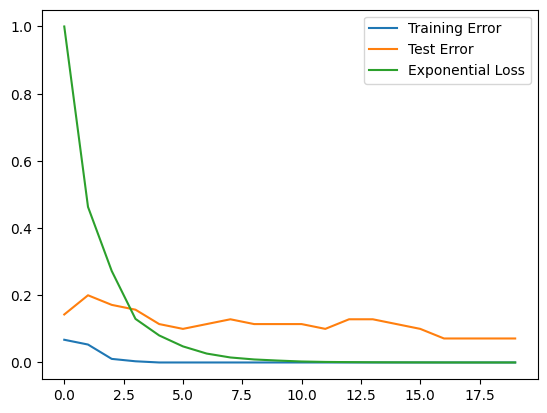

In [30]:
M=20
error_tr=[]
exp_loss=[]
error_te=[]
forest,alphas=boosttree(xTr,yTr,maxiter=20,maxdepth=4)

for i in range(M):
  alpha=alphas[:i+1]
  tr_err=np.mean(np.sign(evalforest(forest[:i+1],xTr,alpha))!=yTr)
  te_error=np.mean(np.sign(evalforest(forest[:i+1],xTe,alpha))!=yTe)
  loss= np.mean(np.exp(-evalforest(forest[:i],xTr,alpha)*yTr))
  error_tr.append(tr_err)
  error_te.append(te_error)
  exp_loss.append(loss)
  print("%d count forest --> test error: %.4f train error: %.4f exponential loss: %.4f " %(i+1,te_error,tr_error,loss))

line_tr,=plt.plot(range(M),error_tr,label="Training Error")
line_te,=plt.plot(range(M),error_te,label="Test Error")
line_trloss,=plt.plot(range(M),exp_loss,label="Exponential Loss")
plt.legend(handles=[line_tr, line_te,line_trloss])

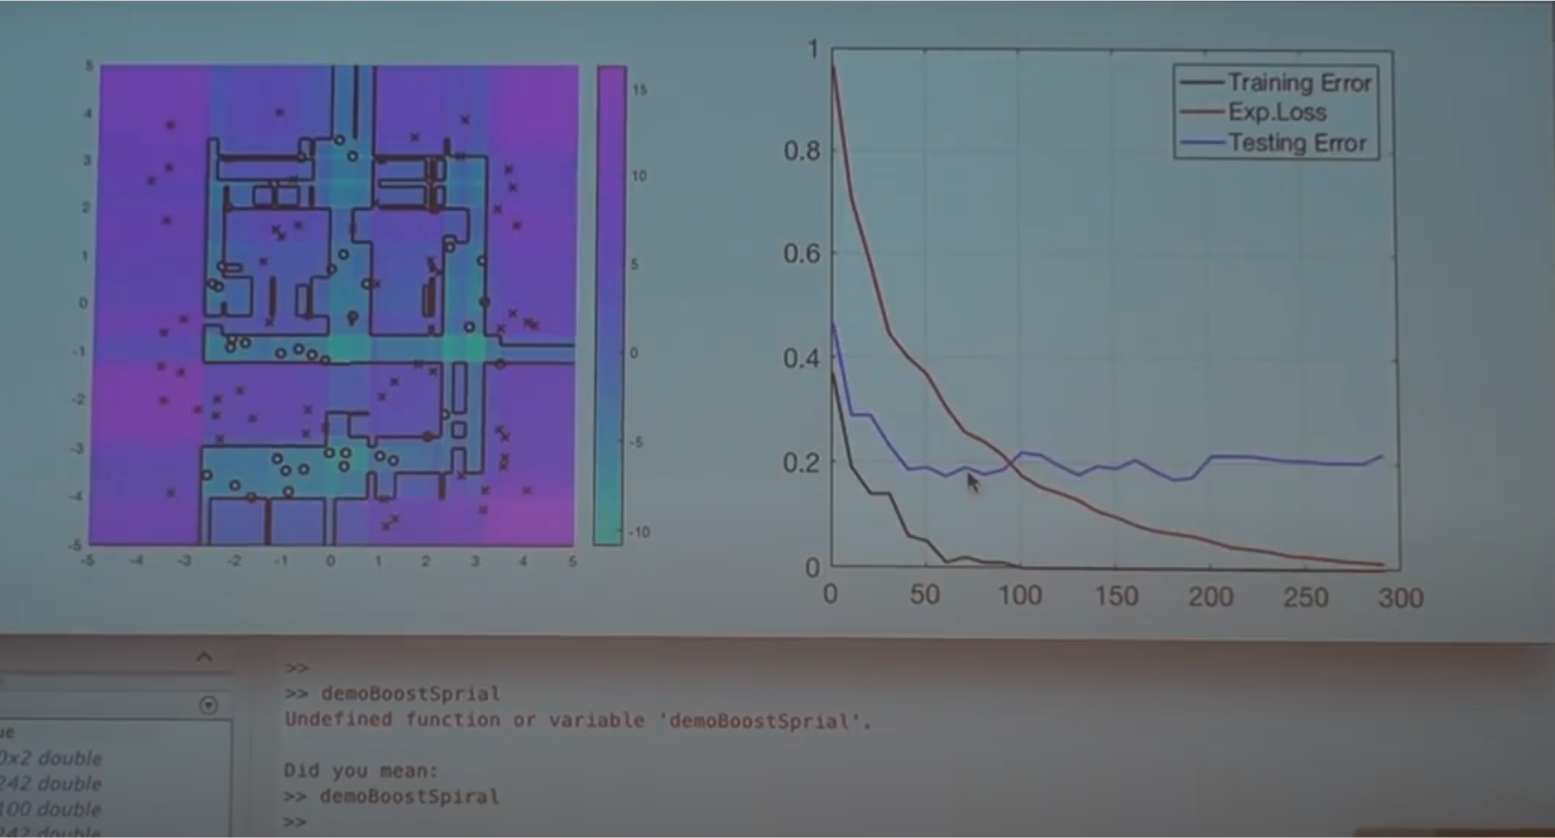

elapsed time: 2.06 seconds
Training error: 0.0000
Testing error:  0.1857


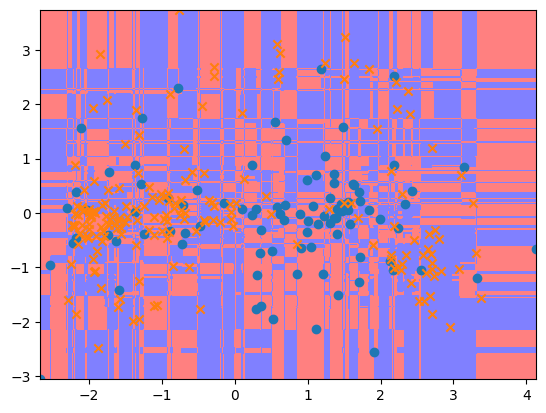

In [31]:
trees,alphas=boosttree(xTr2d,yTr,maxdepth=8,maxiter=50)
visclassifier(lambda X:evalforest(trees,X,alphas),xTr2d,yTr)

print("elapsed time: %.2f seconds" % (t1-t0))
print("Training error: %.4f" % np.mean(np.sign(evalforest(trees,xTr2d)) != yTr))
print("Testing error:  %.4f" % np.mean(np.sign(evalforest(trees,xTe2d)) != yTe))